In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import StandardScaler
from google.colab import drive
%matplotlib inline

# 1. Монтируем Google Диск
drive.mount('/content/drive')

file_path_data = "/content/drive/My Drive/Colab/IKT/IKT_1/data_big.npy"
file_path_etalon = "/content/drive/My Drive/Colab/IKT/IKT_1/etalon_big.npy"
#file_path_etalon = "/etalon.npy"

Mounted at /content/drive


In [ ]:
def preprocess_data(data, etalon, limit = 40): #limits в град/ч

    omega = data[:,[1, 2, 3]]/np.pi*180*200*3600 #перевод в град/ч

    in_peak = False
    begin = 0
    end = 0
    omega_data_cols = [0,1,2]
    transition = np.array([], dtype=int)

    for i in omega_data_cols:
        domega = omega[1:omega.shape[0], i] - omega[0:omega.shape[0]-1, i]
        j=0
        while (j < domega.size):
            if abs(domega[j]) > limit:
                begin = j
                while abs(domega[j]) > limit:
                    j += 1
                end = j
                transition = np.concatenate((transition, np.arange(begin+1, end+1, dtype=int)))
            else:
                j += 1
    print(transition)
    data_corr = np.delete(data, transition, axis=0)
    etalon_corr = np.delete(etalon, transition, axis=0)
    return data_corr, etalon_corr

In [ ]:
def get_diff(X, diff):
  # Вычисляем разницу между текущей и 3-мя строками назад
    diff_real = np.abs(X[3:] - X[:-3])  # Форма (N-3, M)

    # Проверяем условие (хотя бы один элемент в строке < diff)
    condition = np.any(diff_real >= diff, axis=1)  # Форма (N-3,)

    # Получаем индексы строк, где условие True (учитываем смещение +3)
    valid_indices = np.where(condition)[0] + 3  # Индексы исходного массива

    # Создаём итоговую маску (пример: первые 3 элемента + valid_indices)
    mask = np.hstack((np.array([0, 1, 2]), valid_indices))  # Индексы начинаются с 0

    return mask

In [ ]:
def get_coefs_Logictic_Regression_w(X, y, i, diff = 0.0025):

  X.insert(7, 14, X.iloc[:, 0] * X.iloc[:, i-1])
  X.insert(8, 15, X.iloc[:, 1] * X.iloc[:, i-1])
  X.insert(9, 16, X.iloc[:, 2] * X.iloc[:, i-1])

  X.insert(10, 17, X.iloc[:, 0] * X.iloc[:, i-1]**2)
  X.insert(11, 18, X.iloc[:, 1] * X.iloc[:, i-1]**2)
  X.insert(12, 19, X.iloc[:, 2] * X.iloc[:, i-1]**2)

  X.insert(13, 20, X.iloc[:, 0] * X.iloc[:, i-1]**3)
  X.insert(14, 21, X.iloc[:, 1] * X.iloc[:, i-1]**3)
  X.insert(15, 22, X.iloc[:, 2] * X.iloc[:, i-1]**3)

  X.insert(16, 23, X.iloc[:, i-1]**2)
  X.insert(17, 24, X.iloc[:, i-1]**3)

  col_to_drop = []
  for j in range(3, 6):
    if j != i-1:
      col_to_drop.append(j)

  X.drop(X.columns[col_to_drop], axis =1, inplace = True)
  print(X.head())


  X_y = pd.concat([X, y], axis = 1)

  plt.figure(figsize = (12, 8))
  plt.scatter(np.linspace(0, y.shape[0], y.shape[0]), y, alpha=0.05, color = 'red', label = 'etalon')
  plt.scatter(np.linspace(0, X.iloc[:, i-4].shape[0], X.iloc[:, i-4].shape[0]), X.iloc[:, i-4], alpha=0.05, color = 'green', label = 'data')
  plt.xlim(27500, 37500)
  plt.legend()
  plt.show()

  # mask = np.abs(X_y.iloc[:, -1] - X_y.iloc[:, -1].shift(3))
  # X_y = X_y[mask < diff]

  X = X_y.iloc[:, :-1]
  y = X_y.iloc[:, -1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LinearRegression(fit_intercept=True)
  model.fit(X_train, y_train)
  coefs = model.coef_
  intercept = model.intercept_

  to_return = [coefs] + [intercept]

  y_pred = model.predict(X_test)
  error = mean_squared_error(y_test, y_pred)

  y_pred_full = model.predict(X)

  plt.figure(figsize = (12, 8))
  plt.scatter(np.linspace(0, y.shape[0], y.shape[0]), y, alpha=0.05, color = 'red', label = 'etalon')
  plt.scatter(np.linspace(0, y_pred_full.shape[0], y_pred_full.shape[0]), y_pred_full, alpha=0.05, color = 'green', label = 'predict')
  plt.xlim(27500, 37500)
  plt.title(f'new_{i}')
  plt.legend()
  plt.show()

  print('Error for w before:', mean_squared_error(X.iloc[:, i-4], y))
  print('Error for w after:', error)
  return to_return, y_pred_full

In [ ]:
def get_coefs_Logictic_Regression_omega(X, y, i, diff = 0.025):

  """Тут вроде как-то вот так по умному пишут описание функции.
     В данной функции на вход мы получаем фичи и таргеты и строим линейную регрессию"""

  #Добавим новые признаки по индексу
  print(X.head())
  X.insert(7, 14, X.iloc[:, 0] * X.iloc[:, 2+i])
  X.insert(8, 15, X.iloc[:, 1] * X.iloc[:, 2+i])
  X.insert(9, 16, X.iloc[:, 2] * X.iloc[:, 2+i])

  X.insert(10, 17, X.iloc[:, 0] * X.iloc[:, 2+i]**2)
  X.insert(11, 18, X.iloc[:, 1] * X.iloc[:, 2+i]**2)
  X.insert(12, 19, X.iloc[:, 2] * X.iloc[:, 2+i]**2)

  X.insert(13, 20, X.iloc[:, 0] * X.iloc[:, 2+i]**3)
  X.insert(14, 21, X.iloc[:, 1] * X.iloc[:, 2+i]**3)
  X.insert(15, 22, X.iloc[:, 2] * X.iloc[:, 2+i]**3)

  X.insert(16, 23, X.iloc[:, 2+i]**2)
  X.insert(17, 24, X.iloc[:, 2+i]**3)
  X.insert(18, 25, X.iloc[:, i-1]**4)
  X.insert(19, 26, X.iloc[:, i-1]**5)
  X.insert(20, 27, X.iloc[:, i-1]**6)

  X.insert(21, 28, X.iloc[:, 2+i] - X.iloc[:, 10])
  X.drop(10, axis =1, inplace = True)

  col_to_drop = []
  for j in range(3, 6):
    if j != 2+i:
      col_to_drop.append(j)

  X.drop(X.columns[col_to_drop], axis =1, inplace = True)
  print(X.head())

  #В первую очередь нужно выделить ту часть, которая находится на плато, для этого посмотрим на максимальную разность значений на плато
  X_y = pd.concat([X, y], axis = 1)

  #Вот я пока не знаю как подобрать нормально коэффициент, поэтому пока будет так

  # mask = np.abs(X_y.iloc[:, -1] - X_y.iloc[:, -1].shift(3))
  # X_y_sort = X_y.copy()
  # X_y = X_y[mask <= diff]

  X = X_y.iloc[:, :-1]
  y = X_y.iloc[:, -1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LinearRegression(fit_intercept=True)
  model.fit(X_train, y_train)
  coefs = model.coef_
  intercept = model.intercept_

  to_return = [coefs] + [intercept]

  y_pred = model.predict(X)
  #error = mean_squared_error(y_test, y_pred)
  #print(mean_squared_error(X.iloc[:, i-1], y))
  #print(error)
  return to_return, y_pred

In [ ]:
def full_LogicticRegression(file_path_data, file_path_etalon):
  #Подгружаем данные
  data = np.load(file_path_data)
  etalon = np.load(file_path_etalon)

  data, etalon = preprocess_data(data, etalon)

  #Переводим их в датафрейм
  data = pd.DataFrame(data)
  etalon = pd.DataFrame(etalon)

  data = data.dropna()

# Получаем индексы оставшихся строк
  kept_indices = data.index

# Удаляем те же строки в df2
  etalon = etalon.loc[kept_indices]

  nan_count = data.isna().sum()
  print(f'Nan_data = {nan_count}')
  nan_count = etalon.isna().sum()
  print(f"Nan_etalon = {nan_count}")

  np.save(f'Time.npy', data.iloc[:, 0])
  #Разделяем по колонкам для работы с омегой и с ускорением
  print(data.head())
  columns_omega = [1, 2, 3, 7, 8, 9, 10]
  columns_w = [4, 5, 6, 7, 8, 9, 10]
  data_fichi_omega = data[columns_omega]
  data_fichi_w = data[columns_w]

  #Переводим данные: омеги в радианы в секунду, а ускорения в м/с^2
  data_targets_omega = etalon[[1, 2, 3]]/3600*np.pi/180
  data_targets_w = etalon[[4, 5, 6]]

  for i in range(3):
    data_fichi_omega.iloc[:, i] = data_fichi_omega.iloc[:, i]*200
    data_fichi_w.iloc[:, i] = data_fichi_w.iloc[:, i]

  #Тут строим график, чтобы убедиться в правильности преобразований
  # plt.figure(figsize = (18, 15))
  # plt.scatter(data.iloc[:, 0], data_fichi_omega.iloc[:, 0], alpha=0.05)

  # mask = get_diff(data_targets_omega, 0.25)
  # print(data_fichi_omega.index)


  # data_fichi_omega = data_fichi_omega.iloc[mask]
  # data_fichi_w = data_fichi_w.iloc[mask]
  # data_targets_omega = data_targets_omega.iloc[mask]
  # data_targets_w = data_targets_w.iloc[mask]

  # plt.figure(figsize = (15, 7))
  # plt.scatter(data.iloc[:, 0], data_targets_omega.iloc[:, 0], alpha=0.05, label = 'etalon')
  # plt.scatter(data.iloc[:, 0], data_fichi_omega.iloc[:, 0], alpha=0.05, label = 'data')
  # plt.legend()
  # plt.title('omega1')
  # plt.show()


  # plt.figure(figsize = (15, 7))
  # plt.scatter(data.iloc[:, 0], data_targets_omega.iloc[:, 1], alpha=0.05, label = 'etalon')
  # plt.scatter(data.iloc[:, 0], data_fichi_omega.iloc[:, 1], alpha=0.05, label = 'data')
  # plt.legend()
  # plt.title('omega2')
  # plt.show()

  # plt.figure(figsize = (15, 7))
  # plt.scatter(data.iloc[:, 0], data_targets_omega.iloc[:, 2], alpha=0.05, label = 'etalon')
  # plt.scatter(data.iloc[:, 0], data_fichi_omega.iloc[:, 2], alpha=0.05, label = 'data')
  # plt.legend()
  # plt.title('omega3')
  # plt.show()

  # plt.figure()
  # plt.scatter(data.iloc[:, 0], data_targets_w.iloc[:, 0], alpha=0.05, label = 'etalon')
  # plt.scatter(data.iloc[:, 0], data_fichi_w.iloc[:, 0], alpha=0.05, label = 'data')
  # plt.legend()
  # plt.title('g1')
  # plt.show()

  # plt.figure()
  # plt.scatter(data.iloc[:, 0], data_targets_w.iloc[:, 1], alpha=0.05, label = 'etalon')
  # plt.scatter(data.iloc[:, 0], data_fichi_w.iloc[:, 1], alpha=0.05, label = 'data')
  # plt.legend()
  # plt.title('g2')
  # plt.show()

  # plt.figure()
  # plt.scatter(data.iloc[:, 0], data_targets_w.iloc[:, 2], alpha=0.05, label = 'etalon')
  # plt.scatter(data.iloc[:, 0], data_fichi_w.iloc[:, 2], alpha=0.05, label = 'data')
  # plt.legend()
  # plt.title('g3')
  # plt.show()

  # plt.figure()
  # plt.scatter(np.linspace(0, data_targets_w.iloc[:, 0].shape[0], data_targets_w.iloc[:, 0].shape[0]), data_targets_w.iloc[:, 0])
  # plt.xlim(31475, 31500)
  # plt.ylim(0, 2.5)
  # plt.show()

  # plt.figure()
  # plt.scatter(np.linspace(0, data_targets_omega.iloc[:, 2].shape[0], data_targets_omega.iloc[:, 2].shape[0]), data_targets_omega.iloc[:, 2])
  # plt.xlim(31475, 31500)
  # plt.show()


  #Теперь можно начинать лутать коэффициенты
  coefs = {}
  #Тут коэффициенты для омеги
  for target in data_targets_omega.columns:
    coef, y_pred = get_coefs_Logictic_Regression_omega(data_fichi_omega.copy(), data_targets_omega[target], target)
    coefs[f'omega_{target}'] = coef
    np.save(f'array_omega{target}.npy', y_pred)

  #Тут коэффициенты для ускорения
  for target in data_targets_w.columns:
    coef, y_pred = get_coefs_Logictic_Regression_w(data_fichi_w.copy(), data_targets_w[target], target)
    coefs[f'w_{target-3}'] = coef
    np.save(f'array_w{target-3}.npy', y_pred)


  return coefs

[    410     411     417 ... 1631893 1631909 1631910]
Nan_data = 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64
Nan_etalon = 0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
      0             1         2         3         4         5         6   \
0 -0.002 -2.077050e-07 -0.000003  0.000014  0.113404  9.813714  0.144908   
1  0.099 -7.376229e-08 -0.000003  0.000014  0.113634  9.810408  0.143917   
2  0.173 -1.263323e-07 -0.000003  0.000014  0.114116  9.812038  0.144305   
3  0.274  8.681238e-08 -0.000003  0.000014  0.115000  9.809804  0.144251   
4  0.302 -2.104331e-07 -0.000003  0.000014  0.113609  9.811333  0.145998   

      7          8          9          10  
0  13.36   6.666667   0.000000   0.000000  
1  20.04  20.000000  19.910000   6.394118  
2  20.04  20.000000  19.911667  21.740000  
3  20.04  20.000000  19.920000  21.733846  
4  20.04  20.000000  19.920000  21.720000  
         1         2         3      7 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


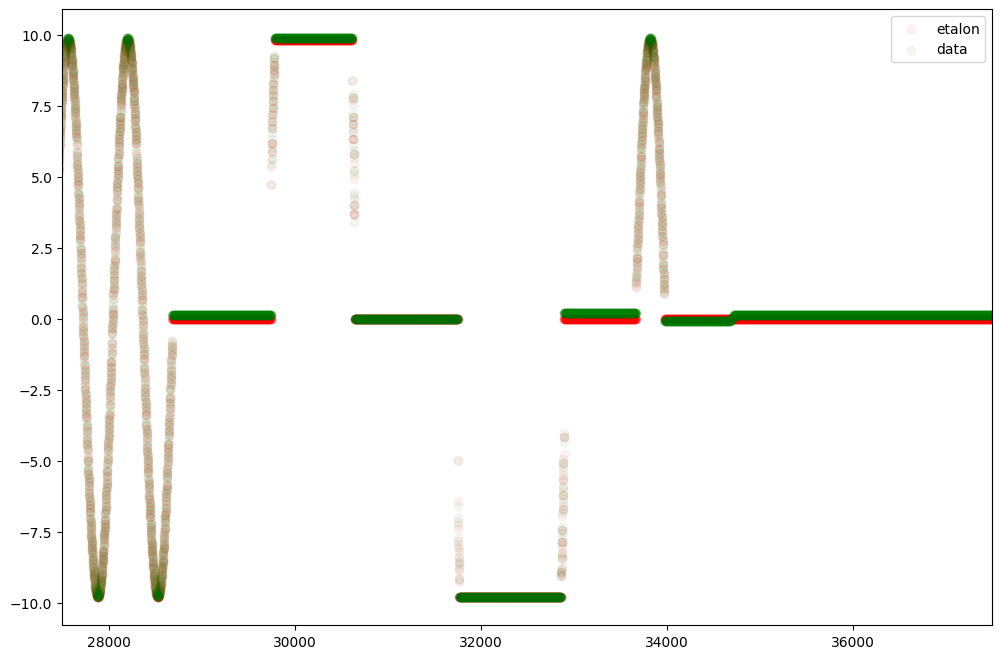

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


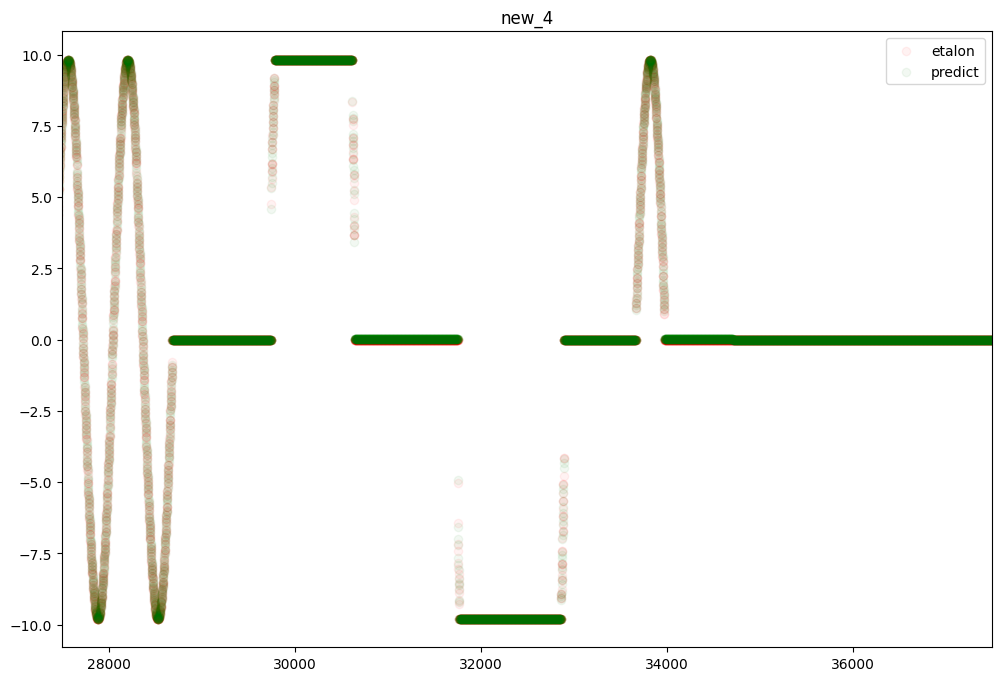

Error for w before: 0.015835202132844135
Error for w after: 0.0021859967906902693
         4         5         6          8          10        14          15  \
0  0.113404  9.813714  0.144908   6.666667   0.000000  0.756024   65.424759   
1  0.113634  9.810408  0.143917  20.000000   6.394118  2.272679  196.208167   
2  0.114116  9.812038  0.144305  20.000000  21.740000  2.282322  196.240766   
3  0.115000  9.809804  0.144251  20.000000  21.733846  2.300004  196.196073   
4  0.113609  9.811333  0.145998  20.000000  21.720000  2.272183  196.226658   

         16         17           18         19          20            21  \
0  0.966056   5.040162   436.165060   6.440375   33.601078   2907.767064   
1  2.878331  45.453589  3924.163348  57.566614  909.071788  78483.266951   
2  2.886093  45.646432  3924.815323  57.721851  912.928640  78496.306462   
3  2.885023  46.000086  3923.921454  57.700464  920.001717  78478.429077   
4  2.919964  45.443652  3924.533152  58.399284  908.873032  784

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


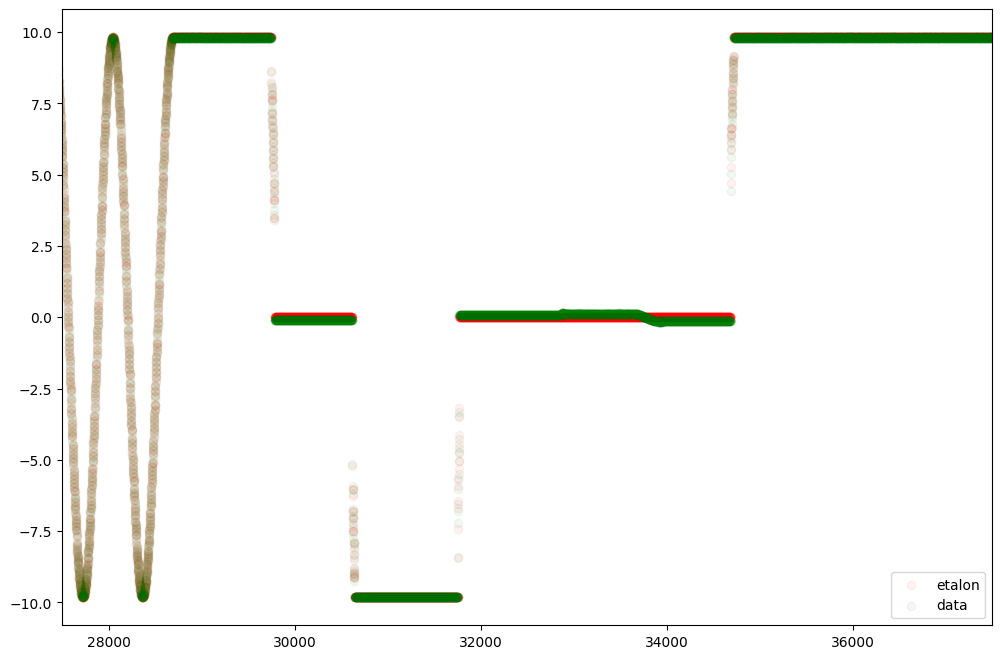

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


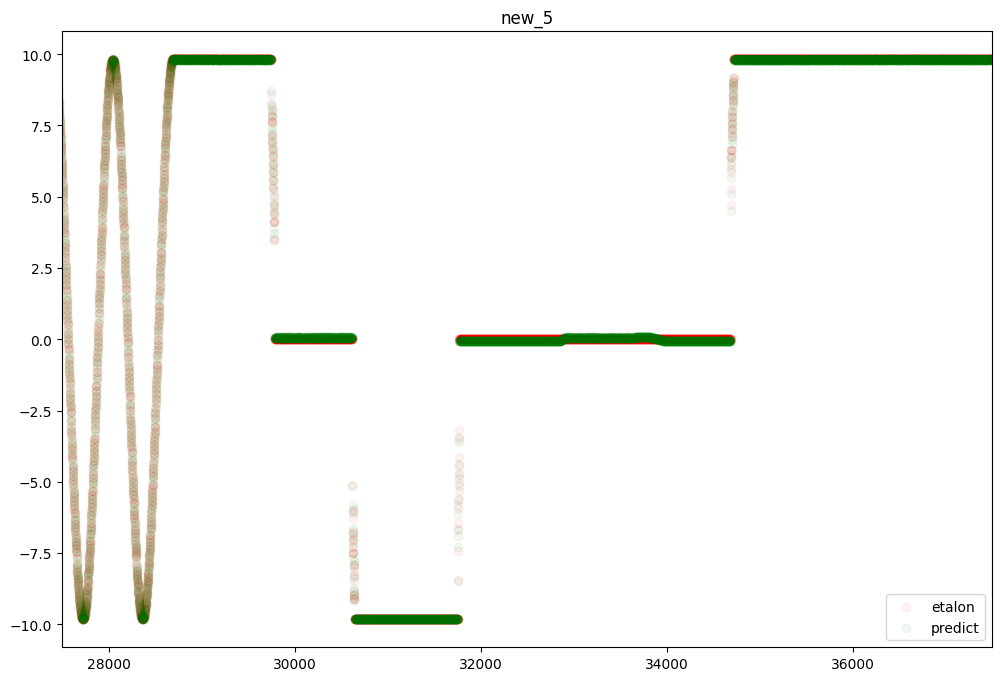

Error for w before: 0.004339196654373911
Error for w after: 0.0030174036982715323
         4         5         6          9          10        14          15  \
0  0.113404  9.813714  0.144908   0.000000   0.000000  0.000000    0.000000   
1  0.113634  9.810408  0.143917  19.910000   6.394118  2.262452  195.325231   
2  0.114116  9.812038  0.144305  19.911667  21.740000  2.272241  195.374036   
3  0.115000  9.809804  0.144251  19.920000  21.733846  2.290804  195.411288   
4  0.113609  9.811333  0.145998  19.920000  21.720000  2.263094  195.441751   

         16         17           18         19          20            21  \
0  0.000000   0.000000     0.000000   0.000000    0.000000      0.000000   
1  2.865378  45.045428  3888.925342  57.049680  896.854462  77428.503553   
2  2.873346  45.244112  3890.222682  57.213101  900.885682  77460.817308   
3  2.873483  45.632821  3892.592865  57.239783  909.005798  77540.449870   
4  2.908284  45.080829  3893.199680  57.933024  898.010123  775

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


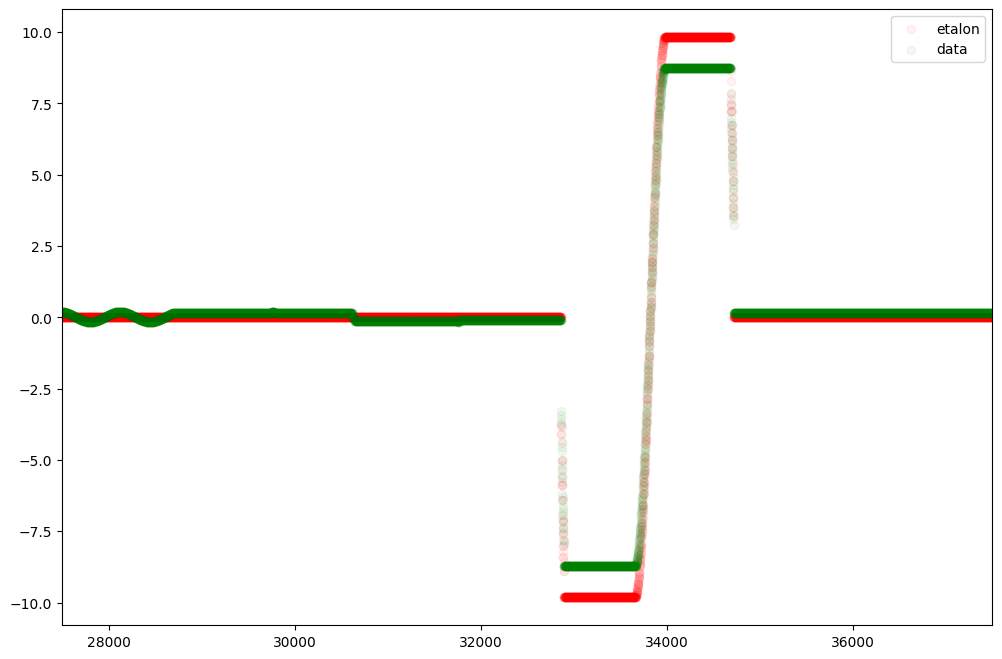

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


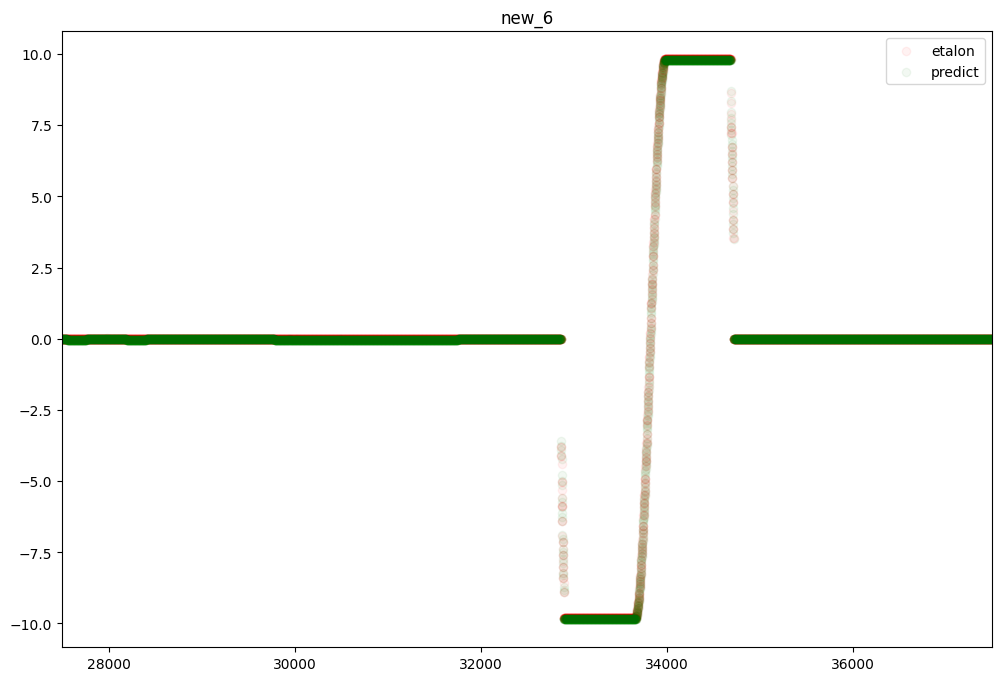

Error for w before: 0.07662532946489702
Error for w after: 0.0020272687945478737


{'omega_1': [array([ 9.97411280e-01, -7.50342237e-03,  1.81459053e-02, -2.22064593e-05,
          3.46287602e-04, -3.92082491e-05, -3.26309580e-05, -1.08807474e-05,
          1.71893822e-06,  2.15441520e-06, -2.23134730e-09, -1.67334485e-08,
         -3.01005866e-08,  8.22718716e-07, -7.72062315e-09, -2.75421221e-02,
         -1.12704706e-02, -4.20679425e-03, -1.13256997e-05]),
  np.float64(0.00037401337810350974)],
 'omega_2': [array([ 1.04138278e-02,  9.93349103e-01,  1.24961681e-02, -3.36541494e-06,
          1.74104599e-05,  3.90456221e-04,  9.99811916e-06, -1.87842117e-06,
         -1.51670312e-06, -1.48101387e-07,  6.96091551e-09,  2.77081051e-08,
          2.64826727e-09,  6.92130824e-08, -1.05789608e-09, -5.80876554e-02,
         -2.29059515e-02, -8.33877919e-03, -1.48699425e-06]),
  np.float64(0.0008874416667268093)],
 'omega_3': [array([-1.79065562e-02, -1.39339852e-02,  9.98082432e-01, -2.40391857e-05,
          1.31796705e-05,  2.26777906e-05,  3.61016089e-04, -1.25867960e-

In [ ]:
full_LogicticRegression(file_path_data, file_path_etalon)

In [ ]:
def print_coefs(filename, coefs_dict):
  coefs_w1 = coefs_dict['w_1']
  KA10 = coefs_w1[0][0] - 1
  KA11 = coefs_w1[0][5]
  KA12 = coefs_w1[0][8]
  KA13 = coefs_w1[0][11]
  GA120 = coefs_w1[0][1]
  GA121 = coefs_w1[0][6]
  GA122 = coefs_w1[0][9]
  GA123 = coefs_w1[0][12]
  GA130 = coefs_w1[0][2]
  GA131 = coefs_w1[0][7]
  GA132 = coefs_w1[0][10]
  GA133 = coefs_w1[0][13]
  a10 = - coefs_w1[1]
  a11 = -coefs_w1[0][3]
  a12 = - coefs_w1[0][14]
  a13 = -coefs_w1[0][15]
  a1MKD = -coefs_w1[0][4]

  coefs_w2 = coefs_dict['w_2']
  KA20 = coefs_w2[0][1] - 1
  KA21 = coefs_w2[0][6]
  KA22 = coefs_w2[0][9]
  KA23 = coefs_w2[0][12]
  GA220 = coefs_w2[0][0]
  GA221 = coefs_w2[0][5]
  GA222 = coefs_w2[0][8]
  GA223 = coefs_w2[0][11]
  GA230 = coefs_w2[0][2]
  GA231 = coefs_w2[0][7]
  GA232 = coefs_w2[0][10]
  GA233 = coefs_w2[0][13]
  a20 = - coefs_w2[1]
  a21 = -coefs_w2[0][3]
  a22 = - coefs_w2[0][14]
  a23 = -coefs_w2[0][15]
  a2MKD = -coefs_w2[0][4]

  coefs_w3 = coefs_dict['w_3']
  KA30 = coefs_w3[0][2] - 1
  KA31 = coefs_w3[0][7]
  KA32 = coefs_w3[0][10]
  KA33 = coefs_w3[0][13]
  GA320 = coefs_w3[0][0]
  GA321 = coefs_w3[0][5]
  GA322 = coefs_w3[0][8]
  GA323 = coefs_w3[0][11]
  GA330 = coefs_w3[0][1]
  GA331 = coefs_w3[0][6]
  GA332 = coefs_w3[0][9]
  GA333 = coefs_w3[0][12]
  a30 = - coefs_w3[1]
  a31 = -coefs_w3[0][3]
  a32 = - coefs_w3[0][14]
  a33 = -coefs_w3[0][15]
  a3MKD = -coefs_w3[0][4]

  coefs_lg1 = coefs_dict['omega_1']
  k10 = coefs_lg1[0][0] - 1
  k11 = coefs_lg1[0][4]
  k12 = coefs_lg1[0][7]
  k13 = coefs_lg1[0][10]
  G120 = coefs_lg1[0][1]
  G121 = coefs_lg1[0][5]
  G122 = coefs_lg1[0][8]
  G123 = coefs_lg1[0][11]
  G130 = coefs_lg1[0][2]
  G131 = coefs_lg1[0][6]
  G132 = coefs_lg1[0][9]
  G133 = coefs_lg1[0][12]
  alg10 = - coefs_lg1[1]
  alg11 = -coefs_lg1[0][3]
  alg12 = - coefs_lg1[0][13]
  alg13 = -coefs_lg1[0][14]
  alg14 = -coefs_lg1[0][15]
  alg15 = -coefs_lg1[0][16]
  alg16 = -coefs_lg1[0][17]
  a1lgMKD = -coefs_lg1[0][18]

  coefs_lg2 = coefs_dict['omega_2']
  k20 = coefs_lg2[0][1] - 1
  k21 = coefs_lg2[0][5]
  k22 = coefs_lg2[0][8]
  k23 = coefs_lg2[0][11]
  G210 = coefs_lg2[0][0]
  G211 = coefs_lg2[0][4]
  G212 = coefs_lg2[0][7]
  G213 = coefs_lg2[0][10]
  G230 = coefs_lg2[0][2]
  G231 = coefs_lg2[0][6]
  G232 = coefs_lg2[0][9]
  G233 = coefs_lg2[0][12]
  alg20 = - coefs_lg2[1]
  alg21 = -coefs_lg2[0][3]
  alg22 = - coefs_lg2[0][13]
  alg23 = -coefs_lg2[0][14]
  alg24 = -coefs_lg2[0][15]
  alg25 = -coefs_lg2[0][16]
  alg26 = -coefs_lg2[0][17]
  a2lgMKD = -coefs_lg2[0][18]

  coefs_lg3 = coefs_dict['omega_3']
  k30 = coefs_lg3[0][2] - 1
  k31 = coefs_lg3[0][6]
  k32 = coefs_lg3[0][9]
  k33 = coefs_lg3[0][12]
  G310 = coefs_lg3[0][0]
  G311 = coefs_lg3[0][4]
  G312 = coefs_lg3[0][7]
  G313 = coefs_lg3[0][10]
  G320 = coefs_lg3[0][1]
  G321 = coefs_lg3[0][5]
  G322 = coefs_lg3[0][8]
  G323 = coefs_lg3[0][11]
  alg30 = - coefs_lg3[1]
  alg31 = -coefs_lg3[0][3]
  alg32 = - coefs_lg3[0][13]
  alg33 = -coefs_lg3[0][14]
  alg34 = -coefs_lg3[0][15]
  alg35 = -coefs_lg3[0][16]
  alg36 = -coefs_lg3[0][17]
  a3lgMKD = -coefs_lg3[0][18]


  with open(filename, 'w') as f:
    f.write(' [PCF_Info]\n')
    f.write('Info=Файл констант подготовлен пользователем\n')
    f.write('Nibl=0;б/р\n')
    f.write('Nver=2024_2603;б/р\n')
    f.write('[Pos]\n')
    f.write('Lat=0.000000000000000E+00;рад.\n')
    f.write('Long=0.000000000000000E+00;рад.\n')
    f.write('Psi=0.000000000000000E+00;рад.\n')
    f.write('LatRMS=0.000000000000000E+00;рад.\n')
    f.write('LongRMS=0.000000000000000E+00;рад.\n')
    f.write('PsiRMS=0.000000000000000E+00;рад.\n')
    f.write('[Corr]\n')
    f.write('DriftLG[X]=0.000000000000000E+00;б/р\n')
    f.write('DriftLG[Y]=0.000000000000000E+00;б/р\n')
    f.write('DriftLG[Z]=0.000000000000000E+00;б/р\n')
    f.write('DriftLGRMS[X]=0.000000000000000E+00;б/р\n')
    f.write('DriftLGRMS[Y]=0.000000000000000E+00;б/р\n')
    f.write('DriftLGRMS[Z]=0.000000000000000E+00;б/р\n')
    f.write('[Adj]\n')
    f.write('Angle[X]=0.000000000000000E+00;рад.\n')
    f.write('Angle[Y]=0.000000000000000E+00;рад.\n')
    f.write('Angle[Z]=0.000000000000000E+00;рад.\n')
    f.write('Paralax[X]=0.000000000000000E+00;м.\n')
    f.write('Paralax[Y]=0.000000000000000E+00;м.\n')
    f.write('Paralax[Z]=0.000000000000000E+00;м.\n')
    f.write('ACRC=0;б/р\n')
    f.write('[Ortho]\n')
    f.write('T0=0.000000000000000E+00;град.С\n')
    f.write('M[00]=1.000000000000000E+00;б/р\n')
    f.write('M[01]=0.000000000000000E+00;б/р\n')
    f.write('M[02]=0.000000000000000E+00;б/р\n')
    f.write('M[10]=0.000000000000000E+00;б/р\n')
    f.write('M[11]=1.000000000000000E+00;б/р\n')
    f.write('M[12]=0.000000000000000E+00;б/р\n')
    f.write('M[20]=0.000000000000000E+00;б/р\n')
    f.write('M[21]=0.000000000000000E+00;б/р\n')
    f.write('M[22]=1.000000000000000E+00;б/р\n')

    f.write('[AC1] \n')
    f.write(f"dK[0]={KA10};б/р\n")
    f.write(f"dK[1]={KA11};1/(град.С)\n")
    f.write(f"dK[2]={KA12};1/(град.С)^2\n")
    f.write(f"dK[3]={KA13};1/(град.С)^3\n")
    f.write(f"da[0]={a10};м/(с^2)\n")
    f.write(f"da[1]={a11};(м/(с^2))/(град.С)\n")
    f.write(f"da[2]={a12};(м/(с^2))/((град.С)^2)\n")
    f.write(f"da[3]={a13};(м/(с^2))/((град.С)^3)\n")
    f.write(f"mA={a1MKD};(м/(с^2))/(град.С)\n")

    f.write(f"dG[10]={GA120};рад.\n")
    f.write(f"dG[11]={GA121};рад./(град.С)\n")
    f.write(f"dG[12]={GA122};рад./((град.С)^2)\n")
    f.write(f"dG[13]={GA123};рад./((град.С)^3)\n")
    f.write(f"dG[20]={GA130};рад.\n")
    f.write(f"dG[21]={GA131};рад./(град.С)\n")
    f.write(f"dG[22]={GA132};рад./((град.С)^2)\n")
    f.write(f"dG[23]={GA133};рад./((град.С)^3)\n")


    f.write('[AC2] \n')
    f.write(f"dK[0]={KA20};б/р\n")
    f.write(f"dK[1]={KA21};1/(град.С)\n")
    f.write(f"dK[2]={KA22};1/(град.С)^2\n")
    f.write(f"dK[3]={KA23};1/(град.С)^3\n")
    f.write(f"da[0]={a20};м/(с^2)\n")
    f.write(f"da[1]={a21};(м/(с^2))/(град.С)\n")
    f.write(f"da[2]={a22};(м/(с^2))/((град.С)^2)\n")
    f.write(f"da[3]={a23};(м/(с^2))/((град.С)^3)\n")
    f.write(f"mA={a2MKD};(м/(с^2))/(град.С)\n")

    f.write(f"dG[10]={GA220};рад.\n")
    f.write(f"dG[11]={GA221};рад./(град.С)\n")
    f.write(f"dG[12]={GA222};рад./((град.С)^2)\n")
    f.write(f"dG[13]={GA223};рад./((град.С)^3)\n")
    f.write(f"dG[20]={GA230};рад.\n")
    f.write(f"dG[21]={GA231};рад./(град.С)\n")
    f.write(f"dG[22]={GA232};рад./((град.С)^2)\n")
    f.write(f"dG[23]={GA233};рад./((град.С)^3)\n")


    f.write('[AC3] \n')
    f.write(f"dK[0]={KA30};б/р\n")
    f.write(f"dK[1]={KA31};1/(град.С)\n")
    f.write(f"dK[2]={KA32};1/(град.С)^2\n")
    f.write(f"dK[3]={KA33};1/(град.С)^3\n")
    f.write(f"da[0]={a30};м/(с^2)\n")
    f.write(f"da[1]={a31};(м/(с^2))/(град.С)\n")
    f.write(f"da[2]={a32};(м/(с^2))/((град.С)^2)\n")
    f.write(f"da[3]={a33};(м/(с^2))/((град.С)^3)\n")
    f.write(f"mA={a3MKD};(м/(с^2))/(град.С)\n")

    f.write(f"dG[10]={GA320};рад.\n")
    f.write(f"dG[11]={GA321};рад./(град.С)\n")
    f.write(f"dG[12]={GA322};рад./((град.С)^2)\n")
    f.write(f"dG[13]={GA323};рад./((град.С)^3)\n")
    f.write(f"dG[20]={GA330};рад.\n")
    f.write(f"dG[21]={GA331};рад./(град.С)\n")
    f.write(f"dG[22]={GA332};рад./((град.С)^2)\n")
    f.write(f"dG[23]={GA333};рад./((град.С)^3)\n")

    #Тут нужны гироскопы
    f.write('[LG1]')

    f.write(f'dK[0]={k10};б/р\n')
    f.write(f'dK[1]={k11};1/(град.С)\n')
    f.write(f'dK[2]={k12};1/(град.С)^2\n')
    f.write(f'dK[3]={k13};1/(град.С)^3\n')

    f.write(f'dw[0]={alg10};рад./с\n')
    f.write(f'dw[1]={alg11};(рад./с)/(град.С)\n')
    f.write(f'dw[2]={alg12};(рад./с)/((град.С)^2)\n')
    f.write(f'dw[3]={alg13};(рад./с)/((град.С)^3)\n')
    f.write(f'dw[4]={alg14};(рад./с)/(град.С^4)\n')
    f.write(f'dw[5]={alg15};(рад./с)/(град.С^5)\n')
    f.write(f'dw[6]={alg16};(рад./с)/(град.С^6)\n')

    f.write(f'mA={a1lgMKD};(рад./с)/(град.С)\n')
    f.write(f'mmA=0;(рад./с)/((град.С)^2)\n')

    f.write(f'G[10]={G120};рад.\n')
    f.write(f'G[11]={G121};рад./(град.С)\n')
    f.write(f'G[12]={G122};рад./((град.С)^2)\n')
    f.write(f'G[13]={G123};рад./((град.С)^3)\n')
    f.write(f'G[20]={G130};рад.\n')
    f.write(f'G[21]={G131};рад./(град.С)\n')
    f.write(f'G[22]={G132};рад./((град.С)^2)\n')
    f.write(f'G[23]={G133};рад./((град.С)^3)\n')

    f.write('[LG2]')

    f.write(f'dK[0]={k20};б/р\n')
    f.write(f'dK[1]={k21};1/(град.С)\n')
    f.write(f'dK[2]={k22};1/(град.С)^2\n')
    f.write(f'dK[3]={k23};1/(град.С)^3\n')

    f.write(f'dw[0]={alg20};рад./с\n')
    f.write(f'dw[1]={alg21};(рад./с)/(град.С)\n')
    f.write(f'dw[2]={alg22};(рад./с)/((град.С)^2)\n')
    f.write(f'dw[3]={alg23};(рад./с)/((град.С)^3)\n')
    f.write(f'dw[4]={alg24};(рад./с)/(град.С^4)\n')
    f.write(f'dw[5]={alg25};(рад./с)/(град.С^5)\n')
    f.write(f'dw[6]={alg26};(рад./с)/(град.С^6)\n')

    f.write(f'mA={a2lgMKD};(рад./с)/(град.С)\n')
    f.write(f'mmA=0;(рад./с)/((град.С)^2)\n')

    f.write(f'G[10]={G210};рад.\n')
    f.write(f'G[11]={G211};рад./(град.С)\n')
    f.write(f'G[12]={G212};рад./((град.С)^2)\n')
    f.write(f'G[13]={G213};рад./((град.С)^3)\n')
    f.write(f'G[20]={G230};рад.\n')
    f.write(f'G[21]={G231};рад./(град.С)\n')
    f.write(f'G[22]={G232};рад./((град.С)^2)\n')
    f.write(f'G[23]={G233};рад./((град.С)^3)\n')


    f.write('[LG3]')

    f.write(f'dK[0]={k30};б/р\n')
    f.write(f'dK[1]={k31};1/(град.С)\n')
    f.write(f'dK[2]={k32};1/(град.С)^2\n')
    f.write(f'dK[3]={k33};1/(град.С)^3\n')

    f.write(f'dw[0]={alg30};рад./с\n')
    f.write(f'dw[1]={alg31};(рад./с)/(град.С)\n')
    f.write(f'dw[2]={alg32};(рад./с)/((град.С)^2)\n')
    f.write(f'dw[3]={alg33};(рад./с)/((град.С)^3)\n')
    f.write(f'dw[4]={alg34};(рад./с)/(град.С^4)\n')
    f.write(f'dw[5]={alg35};(рад./с)/(град.С^5)\n')
    f.write(f'dw[6]={alg36};(рад./с)/(град.С^6)\n')

    f.write(f'mA={a3lgMKD};(рад./с)/(град.С)\n')
    f.write(f'mmA=0;(рад./с)/((град.С)^2)\n')

    f.write(f'G[10]={G310};рад.\n')
    f.write(f'G[11]={G311};рад./(град.С)\n')
    f.write(f'G[12]={G312};рад./((град.С)^2)\n')
    f.write(f'G[13]={G313};рад./((град.С)^3)\n')
    f.write(f'G[20]={G320};рад.\n')
    f.write(f'G[21]={G321};рад./(град.С)\n')
    f.write(f'G[22]={G322};рад./((град.С)^2)\n')
    f.write(f'G[23]={G323};рад./((град.С)^3)\n')

[    410     411     417 ... 1631893 1631909 1631910]
Nan_data = 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64
Nan_etalon = 0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64
      0             1         2         3         4         5         6   \
0 -0.002 -2.077050e-07 -0.000003  0.000014  0.113404  9.813714  0.144908   
1  0.099 -7.376229e-08 -0.000003  0.000014  0.113634  9.810408  0.143917   
2  0.173 -1.263323e-07 -0.000003  0.000014  0.114116  9.812038  0.144305   
3  0.274  8.681238e-08 -0.000003  0.000014  0.115000  9.809804  0.144251   
4  0.302 -2.104331e-07 -0.000003  0.000014  0.113609  9.811333  0.145998   

      7          8          9          10  
0  13.36   6.666667   0.000000   0.000000  
1  20.04  20.000000  19.910000   6.394118  
2  20.04  20.000000  19.911667  21.740000  
3  20.04  20.000000  19.920000  21.733846  
4  20.04  20.000000  19.920000  21.720000  
         1         2         3      7 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


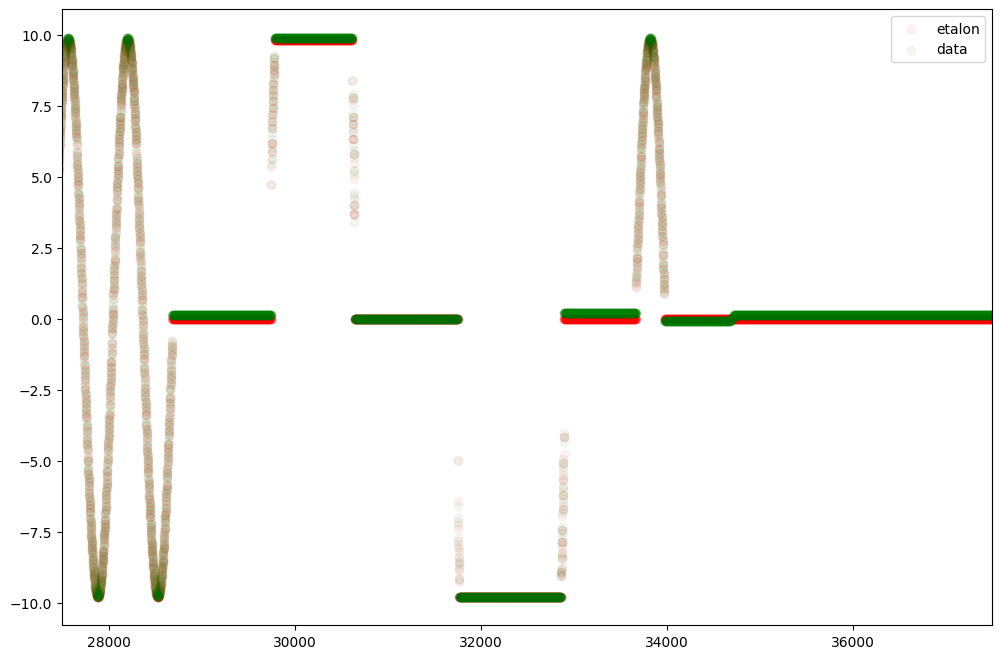

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


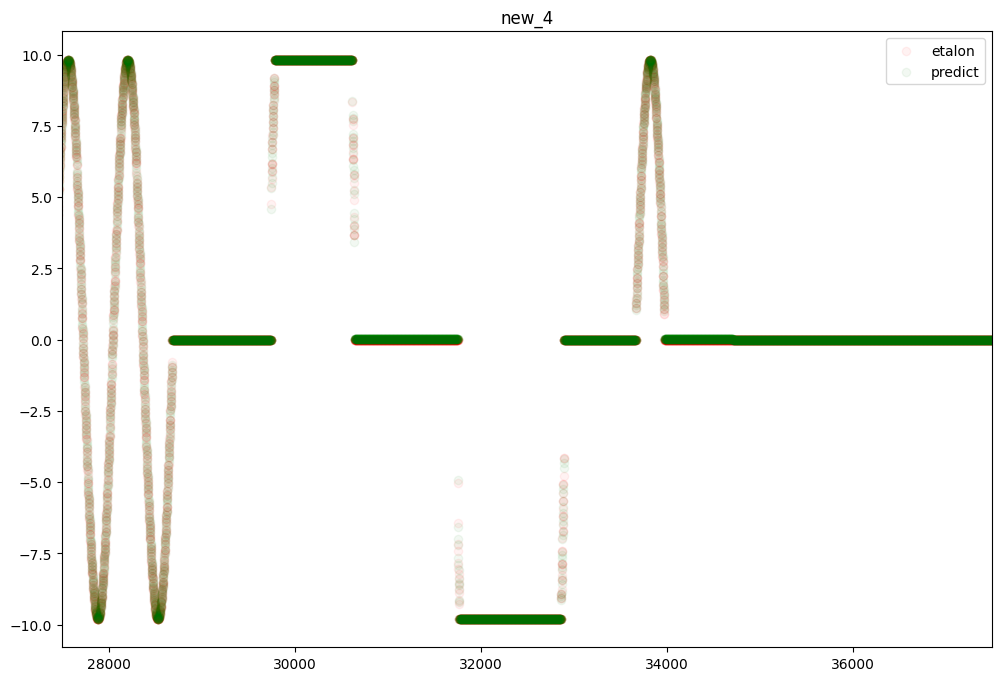

Error for w before: 0.015835202132844135
Error for w after: 0.0021859967906902693
         4         5         6          8          10        14          15  \
0  0.113404  9.813714  0.144908   6.666667   0.000000  0.756024   65.424759   
1  0.113634  9.810408  0.143917  20.000000   6.394118  2.272679  196.208167   
2  0.114116  9.812038  0.144305  20.000000  21.740000  2.282322  196.240766   
3  0.115000  9.809804  0.144251  20.000000  21.733846  2.300004  196.196073   
4  0.113609  9.811333  0.145998  20.000000  21.720000  2.272183  196.226658   

         16         17           18         19          20            21  \
0  0.966056   5.040162   436.165060   6.440375   33.601078   2907.767064   
1  2.878331  45.453589  3924.163348  57.566614  909.071788  78483.266951   
2  2.886093  45.646432  3924.815323  57.721851  912.928640  78496.306462   
3  2.885023  46.000086  3923.921454  57.700464  920.001717  78478.429077   
4  2.919964  45.443652  3924.533152  58.399284  908.873032  784

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


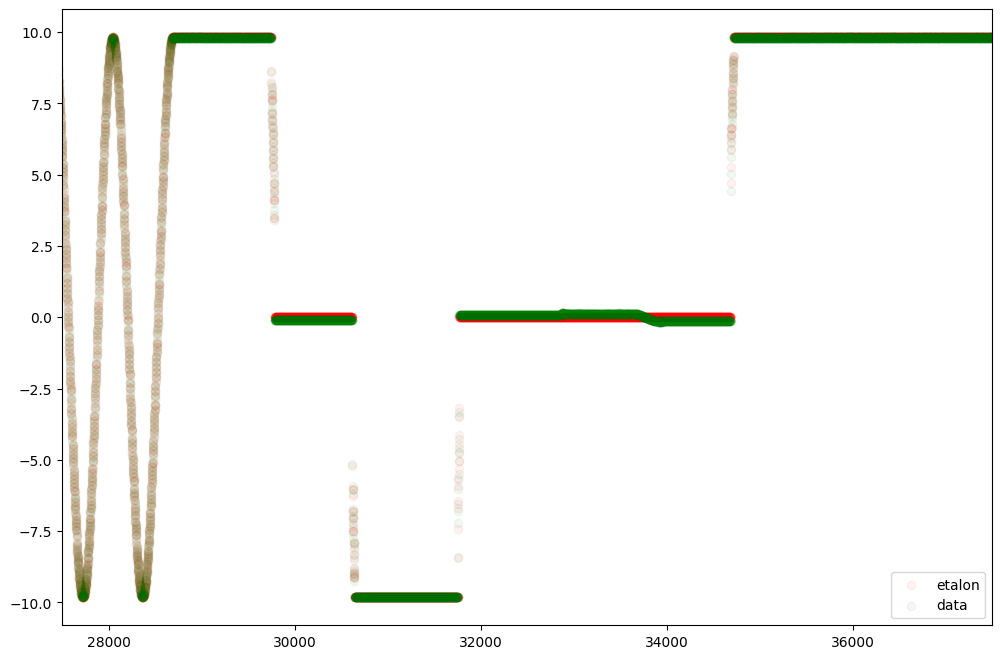

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


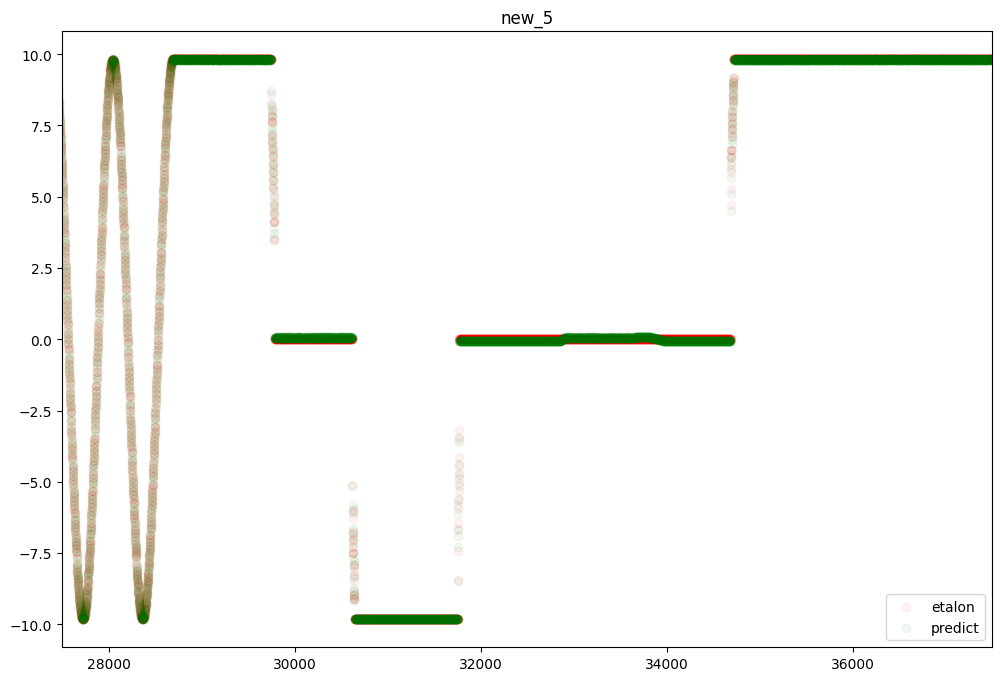

Error for w before: 0.004339196654373911
Error for w after: 0.0030174036982715323
         4         5         6          9          10        14          15  \
0  0.113404  9.813714  0.144908   0.000000   0.000000  0.000000    0.000000   
1  0.113634  9.810408  0.143917  19.910000   6.394118  2.262452  195.325231   
2  0.114116  9.812038  0.144305  19.911667  21.740000  2.272241  195.374036   
3  0.115000  9.809804  0.144251  19.920000  21.733846  2.290804  195.411288   
4  0.113609  9.811333  0.145998  19.920000  21.720000  2.263094  195.441751   

         16         17           18         19          20            21  \
0  0.000000   0.000000     0.000000   0.000000    0.000000      0.000000   
1  2.865378  45.045428  3888.925342  57.049680  896.854462  77428.503553   
2  2.873346  45.244112  3890.222682  57.213101  900.885682  77460.817308   
3  2.873483  45.632821  3892.592865  57.239783  909.005798  77540.449870   
4  2.908284  45.080829  3893.199680  57.933024  898.010123  775

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


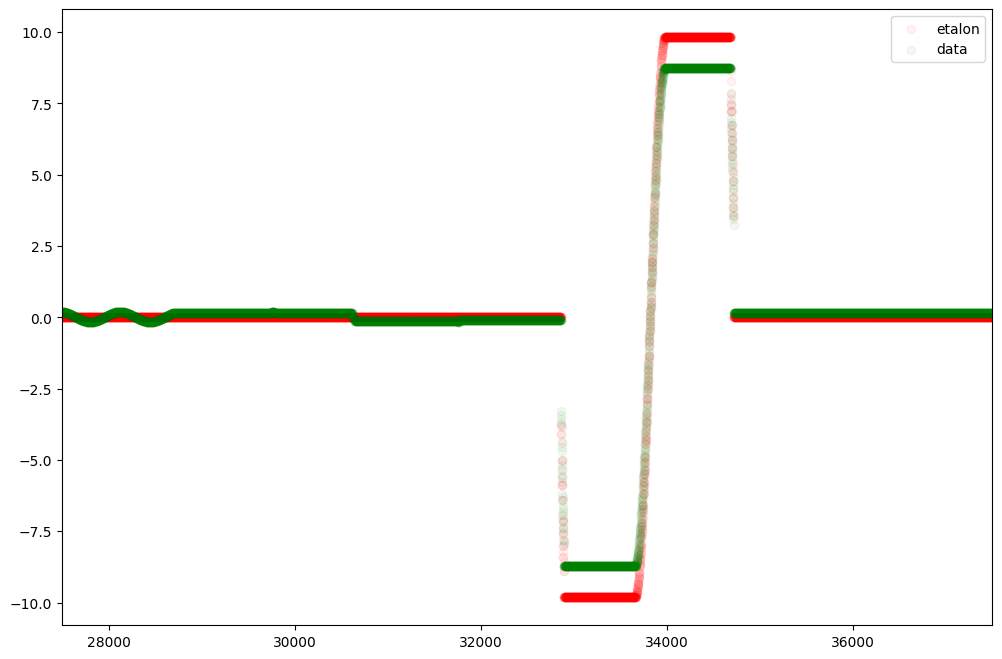

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


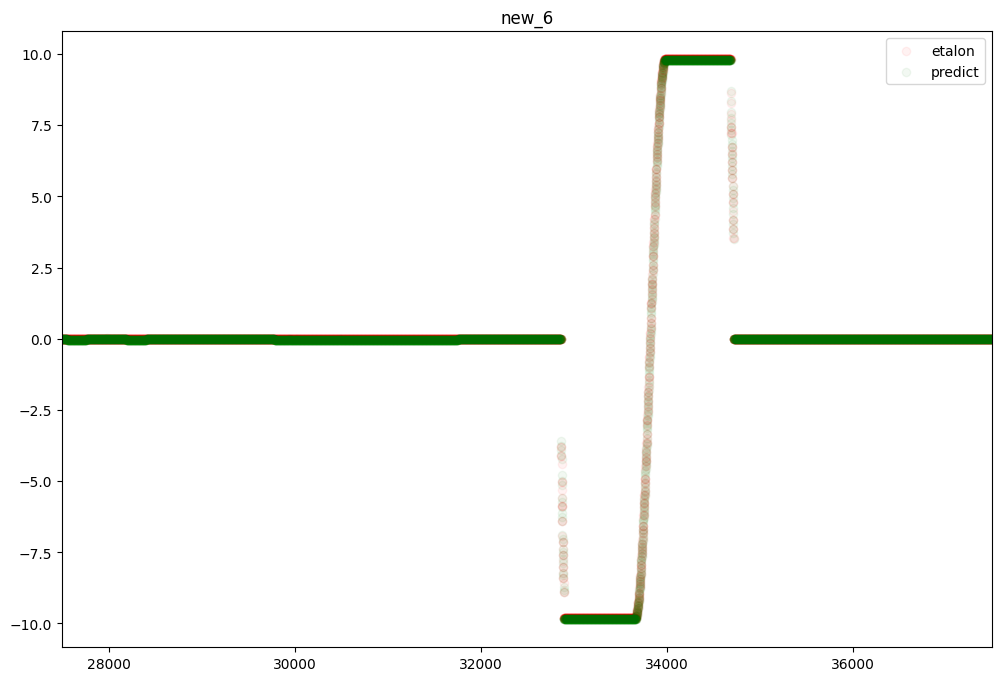

Error for w before: 0.07662532946489702
Error for w after: 0.0020272687945478737


In [ ]:
print_coefs('coefs', full_LogicticRegression(file_path_data, file_path_etalon))